# Discovering Groups

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import metrics
from scipy.cluster import hierarchy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

Data = {'x': [25,34,22,27,33,33,31,22,35,34,67,54,57,43,50,57,59,52,65,47,49,48,35,33,44,45,38,43,51,46],
        'y': [79,51,53,78,59,74,73,57,69,75,51,32,40,47,53,36,35,58,59,50,25,20,14,12,20,5,29,27,8,7]}
  
df = pd.DataFrame(Data,columns=['x','y'])
print(df.head())

    x   y
0  25  79
1  34  51
2  22  53
3  27  78
4  33  59


# K Means Clustering

In [110]:
def euclid_dist(x, y, ax=1):
    return np.linalg.norm(x-y, axis=ax)

In [111]:
def kmeans(df, k):
    N, dim = df.shape
    mu = np.mean(df)
    sig = np.std(df)
    centroids = []
    for i in range(k): #randomly assign centroids
        centroids.append((0.5+np.random.rand(dim))*mu)
    centroids = np.array(centroids)
    diff = 1000
    eps = 0.01
    clusters = np.zeros(N) #to keep track of cluster assignments
    while diff > eps:
        fig, ax = plt.subplots()
        colours = ['y', 'c', 'm']
        for i in range(N):
            row = np.array(df.iloc[i])
            dist = euclid_dist(row, centroids)
            clust = np.argmin(dist)
            clusters[i] = clust #assign samples to centroids
        c_old = np.copy(centroids) #store old centroids
        for i in range(k):  #find new centroids
            samples = [df.iloc[j] for j in range(N) if clusters[j]==i]
            if i in clusters:
                ax.scatter(np.array(samples)[:,0], np.array(samples)[:,1], s=7, c=colours[i])
                centroids[i] = np.mean(samples, axis=0)
        diff = euclid_dist(centroids, c_old, None)
        ax.scatter(centroids[:,0], centroids[:,1], marker='*', color='r')
        print(diff)
    return centroids, clusters

9.663859429793394
23.29330105333728
7.44934369447297
4.9402965114099056
2.3168896731117075
0.0


(array([[29.6, 66.8],
        [43.2, 16.7],
        [55.1, 46.1]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

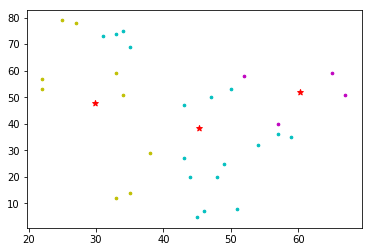

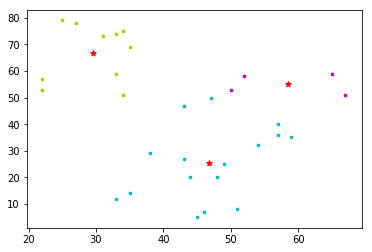

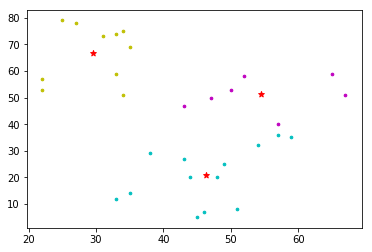

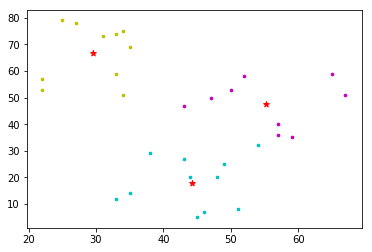

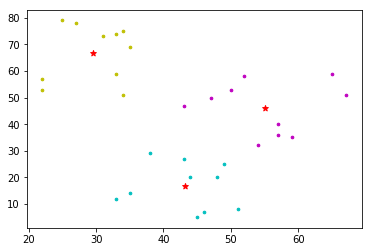

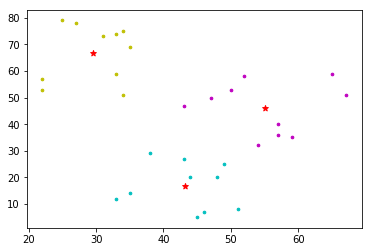

In [112]:
kmeans(df, 3)

# Hierarchical Agglomerative Clustering

In [4]:
def hac(X, labels, dist_metric, min_or_max, centroid_calc):

    p_dict = {}
    c_dict = {}
    centroid_dict={}
    for i in range(len(X)):
        centroid_dict[i] = X[i] # sets each point as centroid
        p_dict[labels[i]] = X[i] #sets name for each data point
        c_dict[i] = [labels[i]] #stores which points are associated with which centroid
    distances=metrics.calc_dist_all(p_dict, dist_metric) #works out all the distances between points
    merge_order = []
    next_cid = len(centroid_dict.keys())
    metrics.plot_grouping(centroid_dict, p_dict, [-2.25, 2.25, -1,2])
    while len(centroid_dict.keys())>1:
        d, c1, c2 = metrics.find_next_merge(distances, centroid_dict, c_dict, p_dict, min_or_max)
        pid_list1 = c_dict[c1]
        pid_list2 = c_dict[c2]
        print(c1, c2, pid_list1, pid_list2)
        clust1 = [p_dict[p_id] for p_id in pid_list1]
        clust2 = [p_dict[p_id] for p_id in pid_list2]

        new_centroid = centroid_calc(clust1, clust2)
        centroid_dict[next_cid] = new_centroid
        c_dict[next_cid] = pid_list1 + pid_list2
        del centroid_dict[c1]
        del centroid_dict[c2]
        metrics.plot_grouping(centroid_dict, p_dict, [-2.25, 2.25, -1,2], d)
        next_cid +=1
    return merge_order

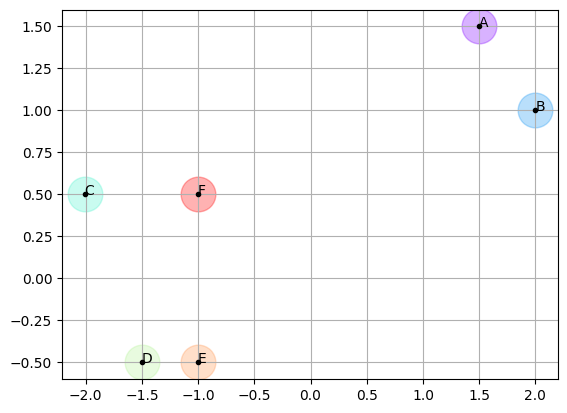

3 4 ['D'] ['E']


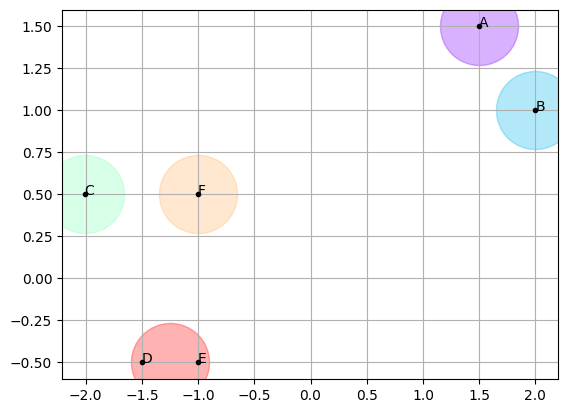

0 1 ['A'] ['B']


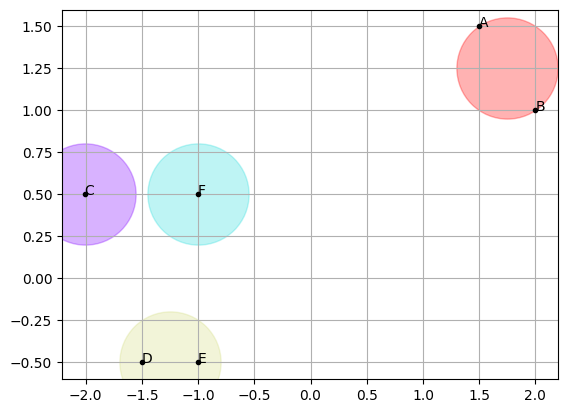

5 6 ['F'] ['D', 'E']


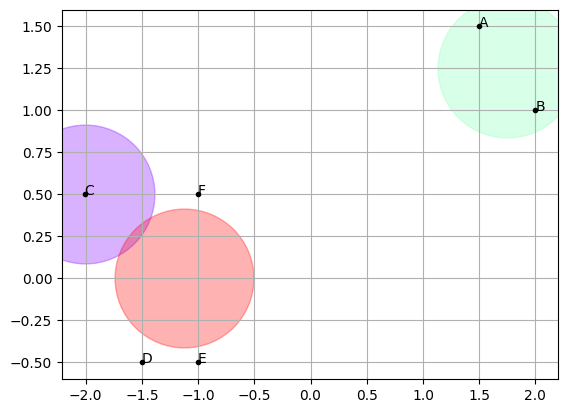

2 8 ['C'] ['F', 'D', 'E']


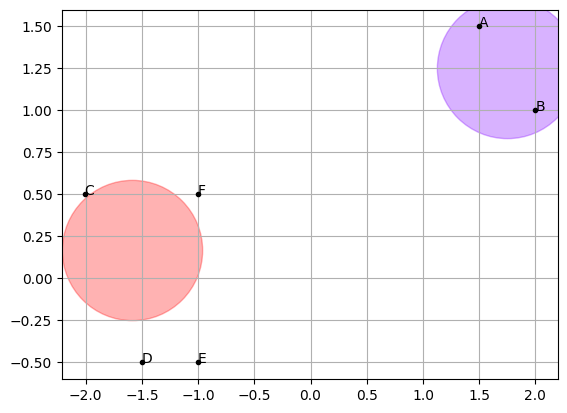

7 9 ['A', 'B'] ['C', 'F', 'D', 'E']


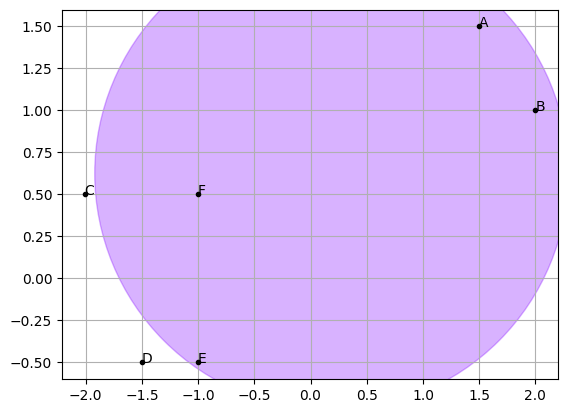

[]

In [7]:
X = np.array([[1.5,1.5], [2,1],[-2.01,0.5], [-1.5,-0.5], [-1,-0.5], [-1,0.5]])
labels=['A', 'B', 'C', 'D', 'E', 'F','G', 'H']
hac(X, labels, metrics.euclid_dist, 'min', metrics.link_WPGMC)


=== Clustering with 6 clusters ===


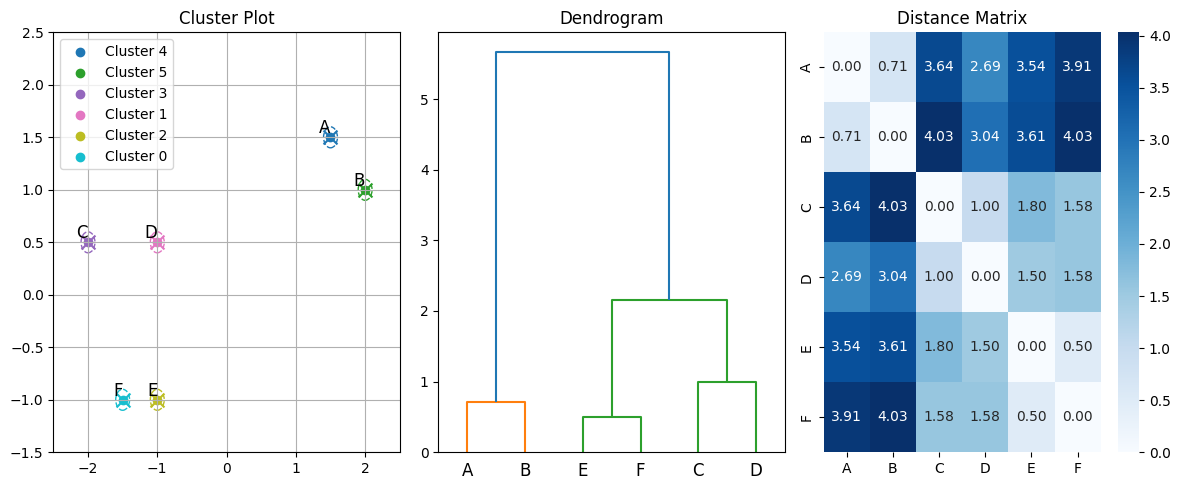


=== Clustering with 5 clusters ===


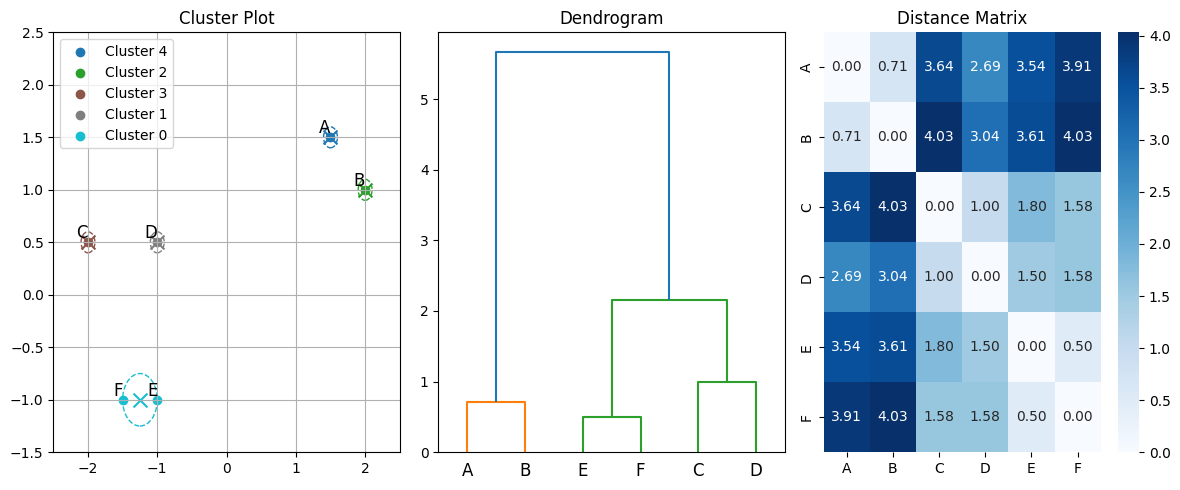


=== Clustering with 4 clusters ===


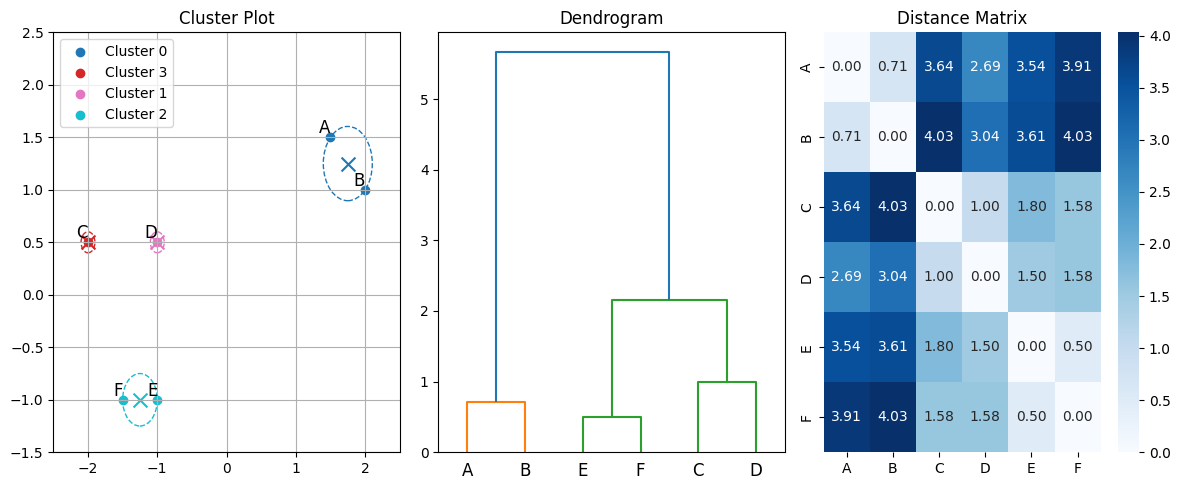


=== Clustering with 3 clusters ===


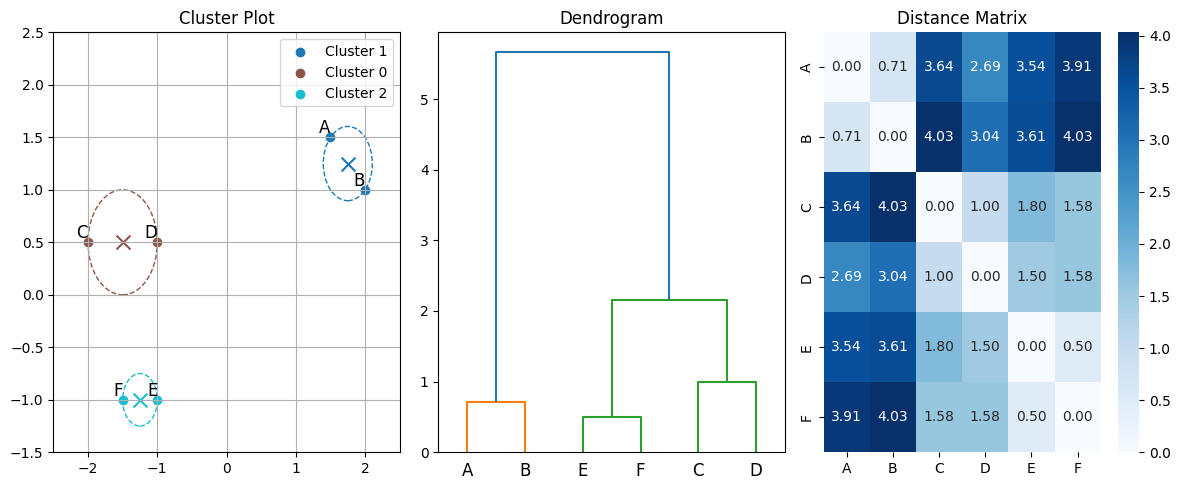


=== Clustering with 2 clusters ===


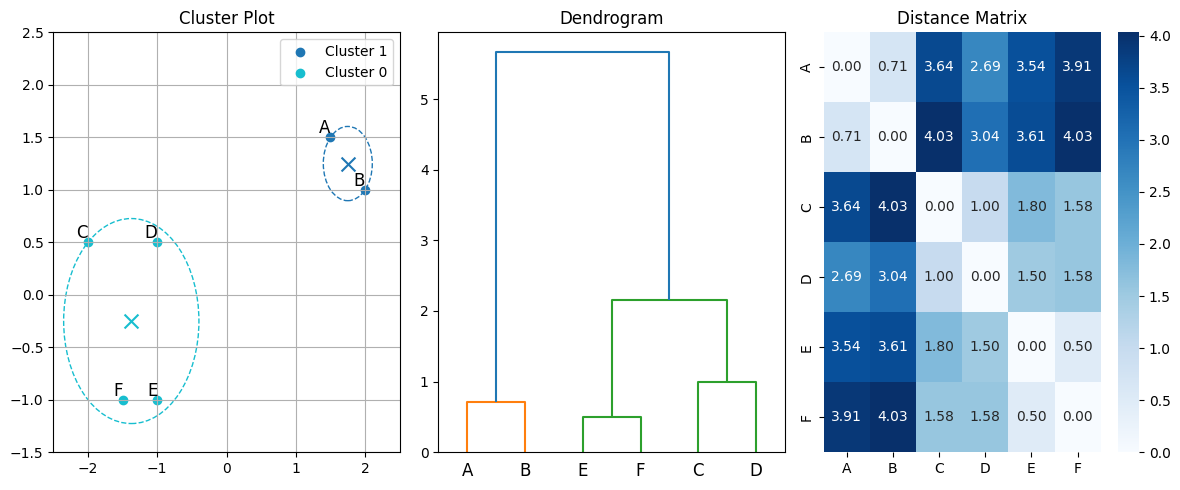


=== Clustering with 1 clusters ===


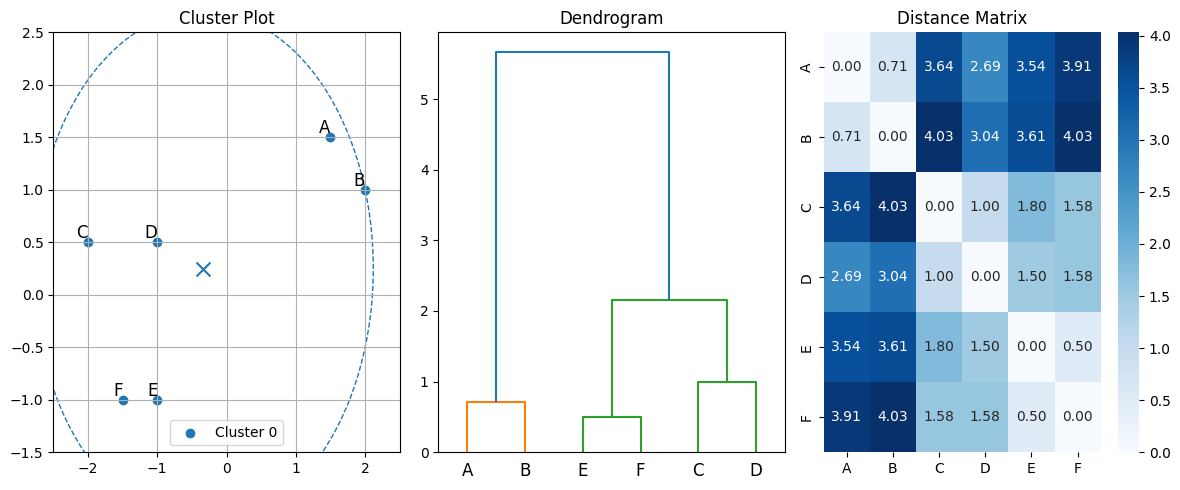

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
from scipy.spatial.distance import pdist, squareform


def plot_grouping(centroids, points, c_dict, bounds, point_labels):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5), gridspec_kw={'width_ratios': [1.5, 1.5, 1.5]})
    ax0, ax1, ax2 = axs

    colors = plt.cm.tab10(np.linspace(0, 1, len(centroids)))

    # --- Scatter Plot with Circles and Labels ---
    for i, (cid, member_ids) in enumerate(c_dict.items()):
        cluster_points = points[member_ids]
        centroid = centroids[cid]
        ax0.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i], label=f'Cluster {cid}')
        ax0.scatter(*centroid, marker='x', color=colors[i], s=100)

        if len(cluster_points) > 1:
            radius = np.max(np.linalg.norm(cluster_points - centroid, axis=1))
        else:
            radius = 0.1
        ax0.add_patch(plt.Circle(centroid, radius, fill=False, linestyle='--', color=colors[i]))

        for idx in member_ids:
            label = point_labels[idx]
            ax0.text(points[idx][0], points[idx][1], label, fontsize=12, ha='right', va='bottom')

    ax0.set_xlim(bounds[0], bounds[1])
    ax0.set_ylim(bounds[2], bounds[3])
    ax0.set_title("Cluster Plot")
    ax0.grid(True)
    ax0.legend()

    # --- Dendrogram ---
    Z = linkage(points, method='ward')
    dendrogram(Z, ax=ax1, labels=point_labels, orientation='top')
    ax1.set_title("Dendrogram")

    # --- Distance Matrix Heatmap ---
    dist_matrix = squareform(pdist(points))
    sns.heatmap(dist_matrix, annot=True, fmt=".2f", xticklabels=point_labels, yticklabels=point_labels, ax=ax2, cmap="Blues")
    ax2.set_title("Distance Matrix")

    plt.tight_layout()
    plt.show()


# HAC with sklearn and proper labeling
def hac_sklearn(X, n_clusters, point_labels):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='single')
    clustering.fit(X)

    # cluster assignments
    cluster_labels = clustering.labels_
    c_dict = {}
    for idx, cid in enumerate(cluster_labels):
        c_dict.setdefault(cid, []).append(idx)

    # compute centroids
    centroids = {cid: np.mean(X[indices], axis=0) for cid, indices in c_dict.items()}

    plot_grouping(centroids, X, c_dict, [-2.5, 2.5, -1.5, 2.5], point_labels)


# Input data
X = np.array([
    [1.5, 1.5],
    [2, 1],
    [-2, 0.5],
    [-1, 0.5],
    [-1, -1.0],
    [-1.5, -1.0]
])

labels = ['A', 'B', 'C', 'D', 'E', 'F']

# Run HAC and plot for different cluster numbers
for n_clusters in range(6, 0, -1):
    print(f"\n=== Clustering with {n_clusters} clusters ===")
    hac_sklearn(X, n_clusters, labels)

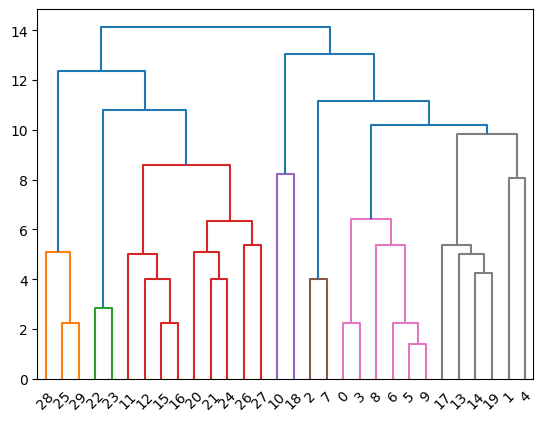

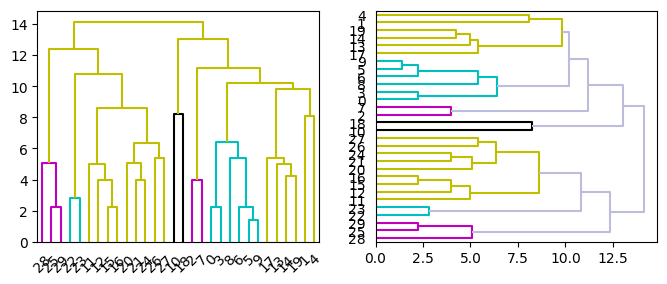

In [35]:
Z = hierarchy.linkage(df, 'single') 
plt.figure()
dn = hierarchy.dendrogram(Z)
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1],above_threshold_color='#bcbddc',orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

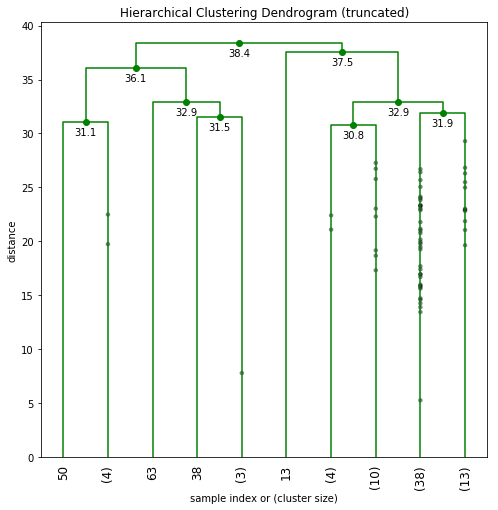

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
temp_scaled = scaler.fit_transform(df)


def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(8,8))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata
from scipy.cluster.hierarchy import dendrogram, ward

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=10,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=80
)

plt.show()        

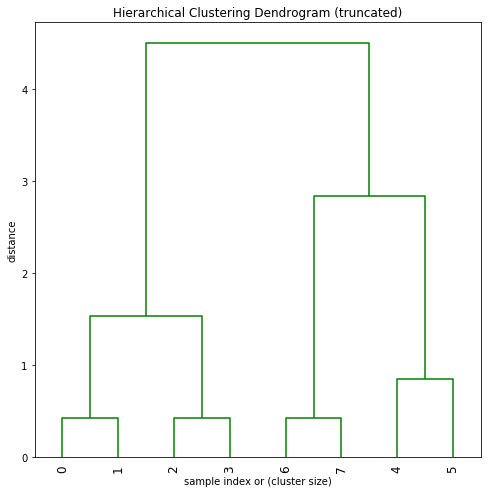

In [5]:

temp_scaled = scaler.fit_transform(X)
linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=10,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=5,
    max_d=80
)

plt.show()  


# Bandwidth

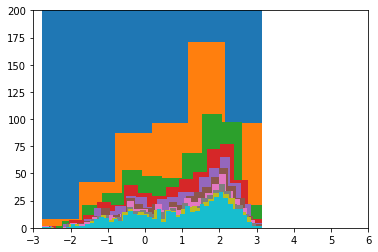

In [125]:
mu = 0.0
sigma=1
n = 500
b = 4
X1 = np.random.normal(mu, sigma, int(n/2))
X2 = np.random.normal(mu+2, sigma/2, int(n/2))
X = np.concatenate((X1, X2))
Y = np.zeros(n)
plt.xlim([-3, 6])
plt.ylim([-0.1, 200])
for b in range(0,50, 5):
    a=plt.hist(X, bins=int(b+1))

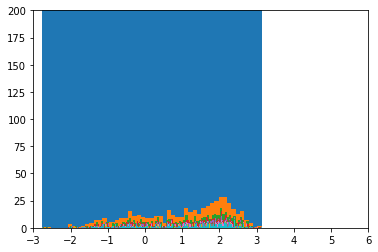

In [126]:
plt.xlim([-3, 6])
plt.ylim([-0.1, 200])
for b in range(0,500, 50):
    a=plt.hist(X, bins=int(b+1))